# Introduction 

In this notebook we will learn the basics of plotting with matplotlib 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import h5py
import yaml
import pickle 
import mplhep as hep
import awkward as ak
import sklearn.metrics as metrics

plt.rcParams['figure.dpi'] = 100

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [4]:
# Let's open the same file
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root" # originally from root://hip-cms-se.csc.fi//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_399.root

file = uproot.open(filename)

In [3]:
# Let make a histogram of jet pt
jet_pt = file["Events"]["ScoutingJet_pt"].array()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


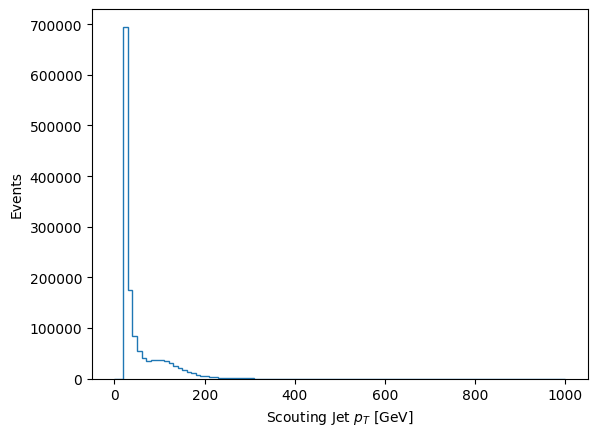

In [15]:
plt.hist(ak.flatten(jet_pt),
         bins=100,
         range = (0,1000),
         histtype='step')
plt.xlabel(r"Scouting Jet $p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon=False)

# Questions

- What is ak.flatten doing here? 
- Can you change the y axis scale to a log scale? 
- Play around with the bin size, what bin size do you think makes sense? 
- Play around with the range, if you remove range = (0,1000), it will autoscale

- Can you plot pt, eta and phi for all Scouting and L1 jets, electrons, and muons?
    - Hint: use for loops to save yourself time
    - Discuss the shape of these distributions with Keith/Jen/Abhi/me


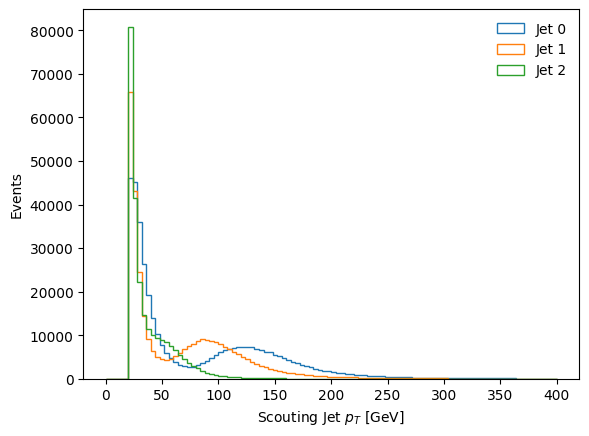

In [25]:
# Now let's plot the "leading" (highest pt), "subleading", second highest pt, and "third leading" jets. 
# In general objects are automatically ordered by pt 


plt.hist(ak.flatten(jet_pt[:,0:1]),
         bins=100,
         range = (0,400),
         label = "Jet 0",
         histtype='step')

plt.hist(ak.flatten(jet_pt[:,1:2]),
         bins=100,
         range = (0,400),
         label = "Jet 1",
         histtype='step')

plt.hist(ak.flatten(jet_pt[:,2:3]),
         bins=100,
         range = (0,400),
         label = "Jet 2",
         histtype='step')

plt.xlabel(r"Scouting Jet $p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon=False)


# Questions
- Can you rewrite this code to use a for loop and plot up to the 10th leading jet? 
- What are the maximum number of scouting jets in an event? 
- What are the maximum number of L1 jets in an event? 
- Try the same for electrons and muons

# Invariant mass distributions

Invariant mass is an incredibly important concept in collider physics. https://en.wikipedia.org/wiki/Invariant_mass Here were will calculate the invariant mass distribution of the leading muons.  

In [1]:
! pip3 install pylorentz

Defaulting to user installation because normal site-packages is not writeable


In [90]:
from pylorentz import Momentum4 # may need to restart notebook after install above

events = file["Events"]
muon_pt  = events["ScoutingMuonVtx_pt"].array()
muon_eta = events["ScoutingMuonVtx_eta"].array()
muon_phi = events["ScoutingMuonVtx_phi"].array()
muon_m   = events["ScoutingMuonVtx_m"].array()
muon_charge = events["ScoutingMuonVtx_charge"].array()

In [91]:
muon_m

<Array [[0], [-1.25e-07], ..., [0], [0, 0]] type='431555 * var * float32'>

In [92]:
# Lets get the leading and subleading muons 
# First lets mask out any events where there are less than two muons per event
at_least_two_muons = ak.num(muon_pt,axis=1)==2
muon_pt  = muon_pt[at_least_two_muons]
muon_eta = muon_eta[at_least_two_muons]
muon_phi = muon_phi[at_least_two_muons]
muon_m   = muon_m[at_least_two_muons]
muon_charge   = muon_charge[at_least_two_muons]

In [93]:
muon_charge

<Array [[-1, -1], [-1, 1], ..., [1, ...], [-1, 1]] type='61487 * var * int32'>

In [101]:
muon1= Momentum4.m_eta_phi_pt(muon_m[:,0], muon_eta[:,0], muon_phi[:,0], muon_pt[:,0])
muon2= Momentum4.m_eta_phi_pt(muon_m[:,1], muon_eta[:,1], muon_phi[:,1], muon_pt[:,1])

In [102]:
dimuon = muon1+muon2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


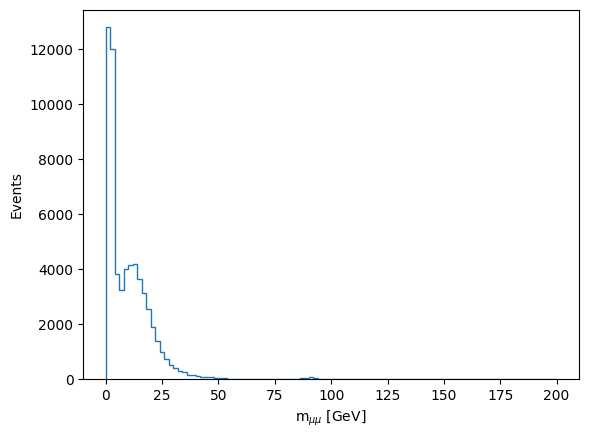

In [107]:
plt.hist(dimuon.m,
         bins=100,
         range = (0,200),
         histtype='step')
plt.xlabel(r"m$_{\mu\mu}$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon=False)

In [108]:
# Now let us require that both muons have an opposite charge (+1-1 = 0)
opposite_charge = ak.sum(muon_charge,axis=1)==0
muon_pt  = muon_pt[opposite_charge]
muon_eta = muon_eta[opposite_charge]
muon_phi = muon_phi[opposite_charge]
muon_m   = muon_m[opposite_charge]
muon_charge   = muon_charge[opposite_charge]

In [109]:
muon1= Momentum4.m_eta_phi_pt(muon_m[:,0], muon_eta[:,0], muon_phi[:,0], muon_pt[:,0])
muon2= Momentum4.m_eta_phi_pt(muon_m[:,1], muon_eta[:,1], muon_phi[:,1], muon_pt[:,1])
dimuon = muon1+muon2

In [112]:
plt.hist(dimuon.m,
         bins=100,
         range = (0,200),
         histtype='step')
plt.xlabel(r"m$_{\mu\mu}$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon=False)
plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Questions

What standard model particle could that peak around 80 GeV correspond to? https://en.wikipedia.org/wiki/Standard_Model 

Are there ways in which you could make this peak even more prominent? E.g. try filtering to select out slightly higher muon pTs. 